# Toy example

In [1]:
import snp2cell
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Create minimal data
### A network with 11 genes

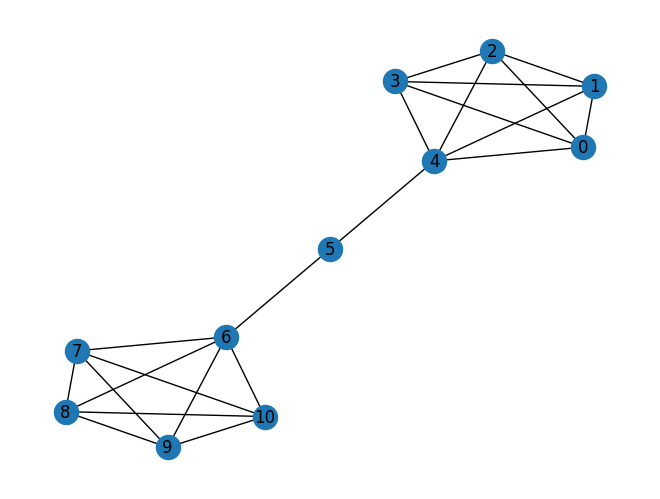

In [2]:
G = nx.barbell_graph(5, 1)
G = nx.relabel_nodes(G, {i: str(i) for i in G})
nx.draw_kamada_kawai(G, with_labels=True)

### A single cell object with 90 cells

In [3]:
df = pd.DataFrame(
    0,
    index=[str(i) for i in np.arange(90)],
    columns=[str(i) for i in np.arange(len(G))],
)
df.iloc[:30, [0, 2, 3]] = 100
df.iloc[30:60, [2, 5, 9]] = 100
df.iloc[60:90, [8, 9, 10]] = 100

ad = sc.AnnData(df)
ad.obs["cell type"] = ["A"] * 30 + ["B"] * 30 + ["C"] * 30

/Users/jp30/miniconda3/envs/snp2cell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jp30/miniconda3/envs/snp2cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


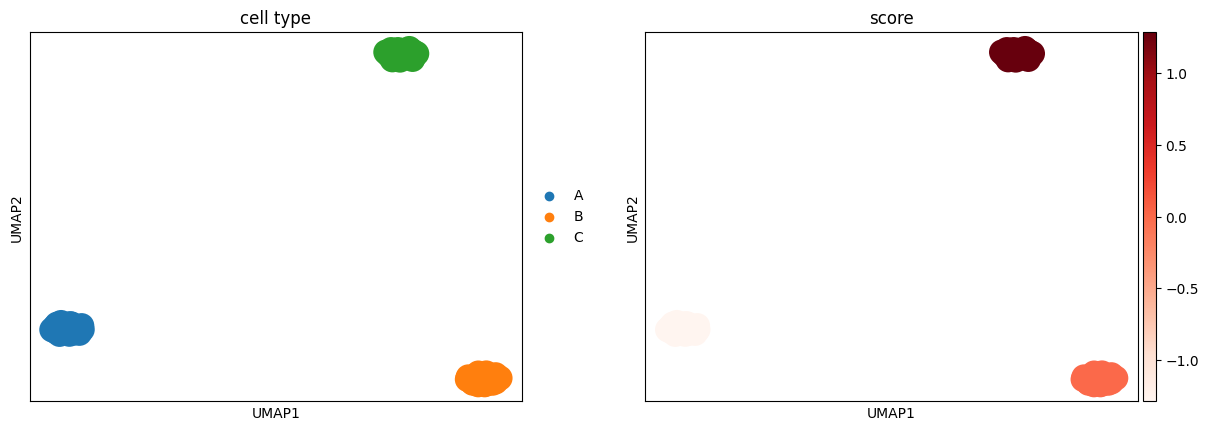

In [4]:
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)
ad.raw = ad
sc.pp.scale(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.score_genes(ad, gene_list=["8", "9"])
sc.pl.umap(ad, color=["cell type", "score"], cmap="Reds")

### Association scores for 4 SNPs

In [5]:
snp_score = {"6": 1, "7": 1, "8": 1, "3": 1, "5": 0}

snp2cell.util.set_num_cpu(1)

## 2) Compute scores
### Initialise a snp2cell object

In [6]:
s2c = snp2cell.SNP2CELL()
s2c.add_grn_from_networkx(G)

### Propagate SNP scores

In [7]:
s2c.add_score(score_dct=snp_score, score_key="snp_score")

[INFO - add_score - 2023-10-07 21:50:53,205]: adding score: snp_score
[INFO - add_score - 2023-10-07 21:50:53,211]: propagating score: snp_score
[INFO - add_score - 2023-10-07 21:50:53,222]: storing score snp_score
[INFO - rand_sim - 2023-10-07 21:50:53,225]: ----- starting rand_sim -----
[INFO - rand_sim - 2023-10-07 21:50:53,228]: create 1000 permutations of score snp_score
[INFO - rand_sim - 2023-10-07 21:50:53,249]: propagating permutations
[INFO - loop_parallel - 2023-10-07 21:50:53,250]: using 1 cores
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.71it/s]
[INFO - rand_sim - 2023-10-07 21:50:57,327]: storing scores under key snp_score
[INFO - rand_sim - 2023-10-07 21:50:57,330]: ----- finished rand_sim -----
[INFO - add_score_statistics - 2023-10-07 21:50:57,331]: ----- starting add_score_statistics -----


### Calculate and propagate marker scores

In [8]:
s2c.link_adata(ad)
s2c.adata_add_de_scores(groupby="cell type", check=False)

[INFO - adata_add_de_scores - 2023-10-07 21:50:57,669]: ----- starting adata_add_de_scores -----
[INFO - adata_add_de_scores - 2023-10-07 21:50:57,670]: finding DE genes for annotation cell type
/Users/jp30/miniconda3/envs/snp2cell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jp30/miniconda3/envs/snp2cell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jp30/miniconda3/envs/snp2cell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
[INFO - adata_add_de_scores - 2023-10-07 21:50:57,722]: ranking by upregulation...
[INFO - add_score - 2023-10-07 21:50:57,731]: adding score: DE_A__score
[INFO - add_score - 

### Combine SNP and marker scores

In [9]:
s2c.adata_combine_de_scores(
    group_key="cell type", score_key="snp_score", suffix="__zscore"
)

[INFO - combine_scores - 2023-10-07 21:51:02,742]: ----- starting combine_scores -----
[INFO - combine_scores - 2023-10-07 21:51:02,743]: combining scores: [('DE_A__score__zscore', 'snp_score__zscore'), ('DE_C__score__zscore', 'snp_score__zscore'), ('DE_B__score__zscore', 'snp_score__zscore')]
[INFO - combine_scores - 2023-10-07 21:51:02,745]: ----- finished combine_scores -----
[INFO - combine_scores_rand - 2023-10-07 21:51:02,745]: ----- starting combine_scores_rand -----
[INFO - combine_scores_rand - 2023-10-07 21:51:02,746]: combining scores: [('DE_cell type__score', 'snp_score', '__zscore')]
[INFO - combine_scores_rand - 2023-10-07 21:51:02,762]: ----- finished combine_scores_rand -----
[INFO - add_score_statistics - 2023-10-07 21:51:02,763]: ----- starting add_score_statistics -----
[INFO - add_score_statistics - 2023-10-07 21:51:02,763]: adding statistics for: {'min(DE_A__score__zscore,snp_score__zscore)': 'min(DE_cell type__score__zscore,snp_score__zscore)', 'min(DE_C__score__z

## 3) Plots
### A heatmap
Note that cell type `C` has the largest scores overall, since cell type `C` marker scores overlap most with
the SNP scores. Cell type `B` shares some high scoring genes with `C`, while `A` has the lowest scores.
The rows indicate which subnetwork of genes may be involved in the trait (the lower fully connected graph in the
plot above).

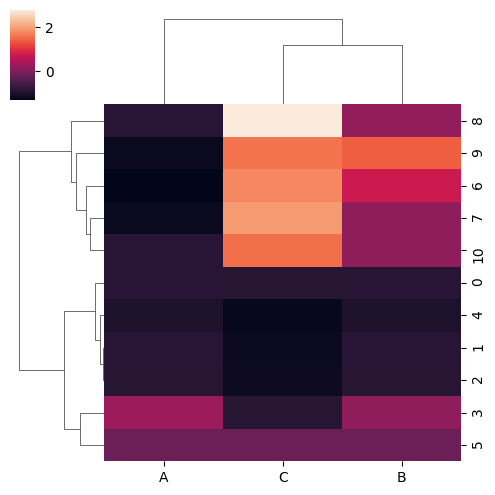

In [10]:
plt_df = s2c.get_scores(regex="min.+snp_score__zscore.*zscore$")
plt_df = plt_df.rename(columns=s2c.rename_column)

sns.clustermap(plt_df, figsize=(5, 5))

### The gene network
Scores can also be plotted on the gene network. Top row: original scores. Middle row: propagated scores.
Bottom row scores are corrected against a background of random permutations and the 3 rightmost columns at the bottom
show overlapped SNP and marker scores. The combined score for `C` is largest (note the scale) and points to the
lower densely connected subnetwork.

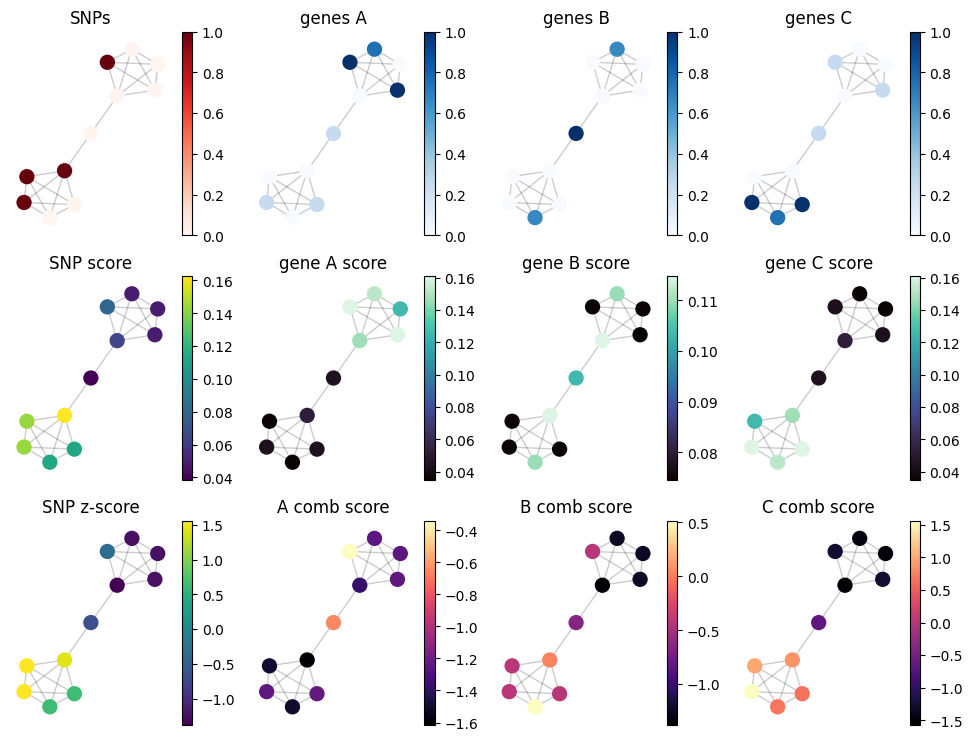

In [11]:
plot_scores = [
    (s2c.scores["snp_score"], "Reds", "SNPs"),
    (s2c.scores["DE_A__score"], "Blues", "genes A"),
    (s2c.scores["DE_B__score"], "Blues", "genes B"),
    (s2c.scores["DE_C__score"], "Blues", "genes C"),
    (s2c.scores_prop["snp_score"], "viridis", "SNP score"),
    (s2c.scores_prop["DE_A__score"], "mako", "gene A score"),
    (s2c.scores_prop["DE_B__score"], "mako", "gene B score"),
    (s2c.scores_prop["DE_C__score"], "mako", "gene C score"),
    (s2c.scores_prop["snp_score__zscore"], "viridis", "SNP z-score"),
    (
        s2c.scores_prop["min(DE_A__score__zscore,snp_score__zscore)"],
        "magma",
        "A comb score",
    ),
    (
        s2c.scores_prop["min(DE_B__score__zscore,snp_score__zscore)"],
        "magma",
        "B comb score",
    ),
    (
        s2c.scores_prop["min(DE_C__score__zscore,snp_score__zscore)"],
        "magma",
        "C comb score",
    ),
]
nrow, ncol = 3, 4
plt.rcParams["figure.figsize"] = (ncol * 3, nrow * 3)
fig, axs = plt.subplots(nrow, ncol)
pos = nx.kamada_kawai_layout(G)
for k, (score_val, col_map, ax_title) in enumerate(plot_scores):
    i, j = int(k) // 4, k % 4
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2, ax=axs[i, j])
    nc = nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=s2c.scores_prop.index.tolist(),
        node_color=score_val.tolist(),
        node_size=100,
        cmap=plt.colormaps[col_map],
        ax=axs[i, j],
    )
    plt.colorbar(nc)
    axs[i, j].set_title(ax_title)
    axs[i, j].axis("off")